In [ ]:
#Use mulitlinear regression to see how age, sex, bmi, children, smoker, and region can be used to predict medical charges amount

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/insurance.csv'

df = pd.read_csv(file_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
#Alex Ferrone
#Find any NA values
print(df.isna().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [ ]:
#Alex Ferrone
df['child_bool'] = df['children'] > 0
df.head()

,age,sex,bmi,children,smoker,region,charges,child_bool
0,19,female,27.900,0,yes,southwest,16884.92400,False
1,18,male,33.770,1,no,southeast,1725.55230,True
2,28,male,33.000,3,no,southeast,4449.46200,True
3,33,male,22.705,0,no,northwest,21984.47061,False
4,32,male,28.880,0,no,northwest,3866.85520,False


In [ ]:
#Alex Ferrone
#See unique number of values
unique_counts = df.nunique()
print(unique_counts)

age             47
sex              2
bmi            548
children         6
smoker           2
region           4
charges       1337
child_bool       2
dtype: int64


In [ ]:
#Alex Ferrone
#Summary statistics
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


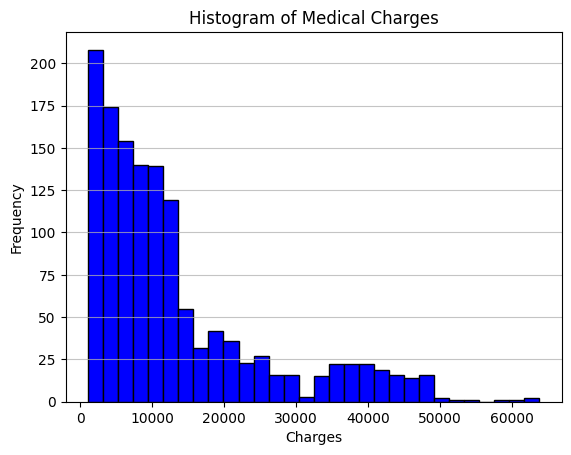

In [ ]:
#Alex Ferrone
#Histogram of our dependent variable shows a high level of skewness and a potential outlier
plt.hist(df['charges'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Charges')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.title('Histogram of Medical Charges')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
#Alex Ferrone
#We can see there are indeed outliers at 3 standard deviations from the mean and there is a very large variance.
charges = df['charges']

mean = np.mean(charges)
min = np.min(charges)
max = np.max(charges)
std = np.std(charges)
var = np.var(charges)

zScores = np.abs((charges - mean) / std)

outliers = np.sum(zScores > 3)

print(f'There are {outliers} outliers in charges at 3 standard deviations from the mean.')
print(f'The mean is {round(mean,2)}, the minimum value is {min}, and the maximum value is {max}.')
print(f'The standard deviation is {round(std,3)} and the variance is {round(var,3)}.')

There are 7 outliers in charges at 3 standard deviations from the mean.
The mean is 13270.42, the minimum value is 1121.8739, and the maximum value is 63770.42801.
The standard deviation is 12105.485 and the variance is 146542766.494.


In [ ]:
#Alex Ferrone
#Considered taking out the outliers but they are likely still representative of the dataset
"""
df = df[zScores >= 3]
plt.hist(df['charges'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Charges')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.title('Histogram of Medical Charges')
plt.grid(axis='y', alpha=0.75)
plt.show()
"""

"\ndf = df[zScores >= 3]\nplt.hist(df['charges'], bins=30, color='blue', edgecolor='black')\nplt.xlabel('Charges')  # Label for the x-axis\nplt.ylabel('Frequency')  # Label for the y-axis\nplt.title('Histogram of Medical Charges')\nplt.grid(axis='y', alpha=0.75)\nplt.show()\n"

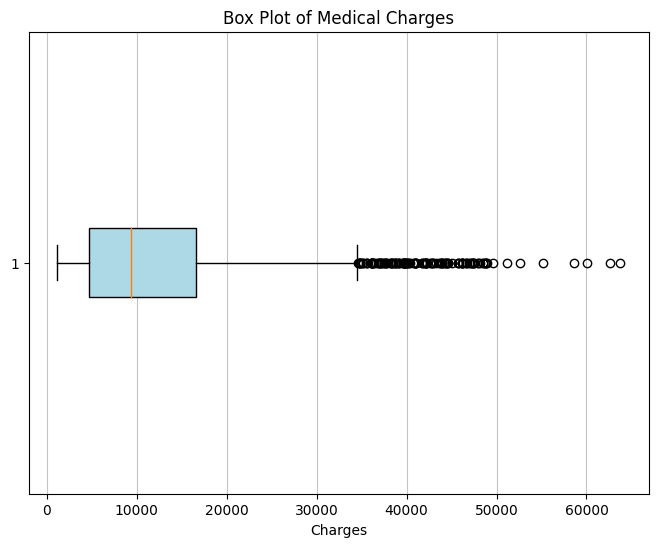

In [ ]:
#Alex Ferrone
plt.figure(figsize=(8, 6))
plt.boxplot(df['charges'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue'))
plt.xlabel('Charges')
plt.title('Box Plot of Medical Charges')
plt.grid(axis='x', alpha=0.75)
plt.show()

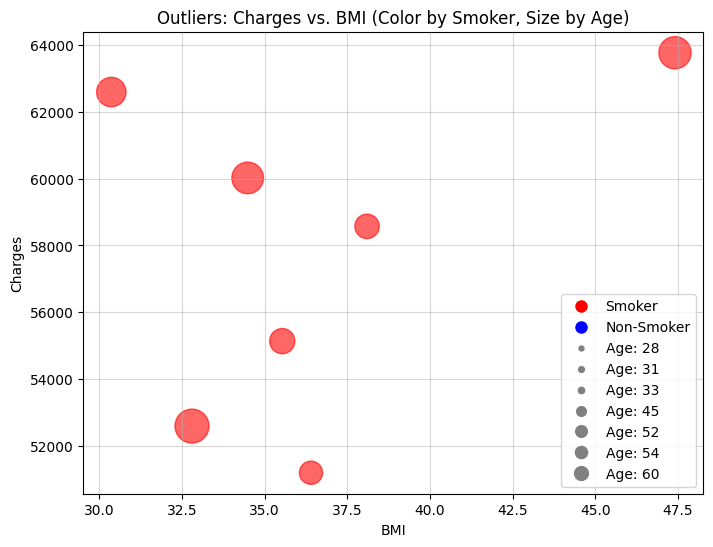

In [ ]:
#Alex Ferrone
# Filter out the outliers based on charges
outliers = df[df['charges'] >= (df['charges'].mean() + 3 * df['charges'].std())]
colors = outliers['smoker'].map({'yes': 'red', 'no': 'blue'})
bubble_size = outliers['age'] * 10

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(outliers['bmi'], outliers['charges'], c=colors, s=bubble_size, alpha=0.6)

# Custom legend
legend_elements  = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Smoker'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Non-Smoker')]

# Adding individual ages to the legend
for age in sorted(outliers['age'].unique()):
    legend_elements.append(
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                   markersize=(age / 5), label=f'Age: {age}')
    )

plt.legend(handles=legend_elements)
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.title('Outliers: Charges vs. BMI (Color by Smoker, Size by Age)')
plt.grid(alpha=0.5)
plt.show()

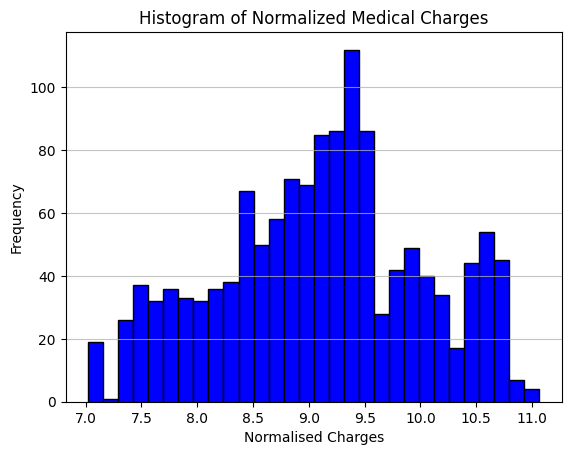

In [ ]:
#Alex Ferrone
#Normalize the data to reduce skewness
df['norm_charges'] = np.log(df['charges'])

plt.hist(df['norm_charges'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Normalised Charges')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.title('Histogram of Normalized Medical Charges')
plt.grid(axis='y', alpha=0.75)
plt.show()

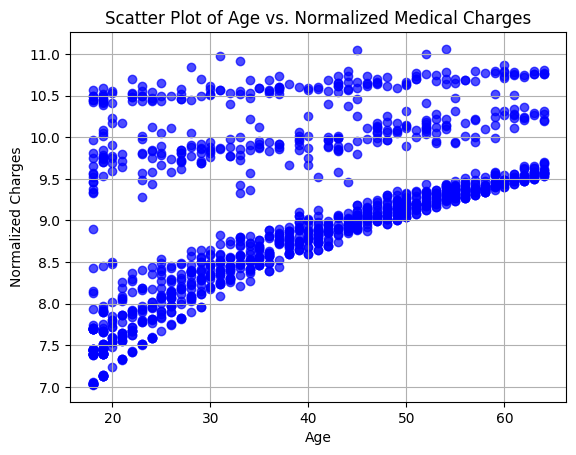

In [ ]:
#Alex Ferrone

plt.scatter(df['age'], df['norm_charges'], color='blue', alpha=0.7)
# Label for the x-axis
plt.xlabel('Age')
# Label for the y-axis
plt.ylabel('Normalized Charges')
# Title of the plot
plt.title('Scatter Plot of Age vs. Normalized Medical Charges')
plt.grid(True)
plt.show()

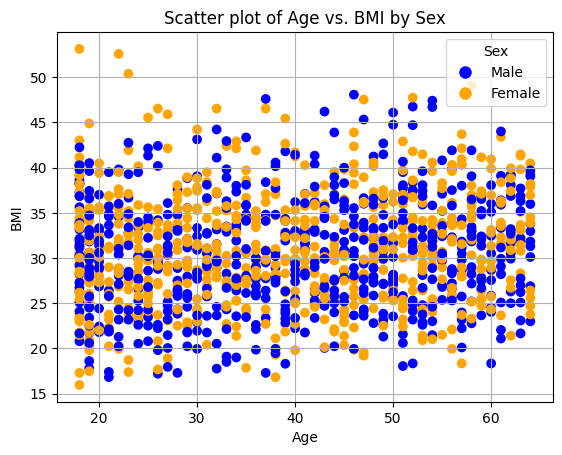

In [ ]:
#Alex Ferrone
sex_codes = pd.Categorical(df['sex']).codes

# Define custom colors
colors = ['blue' if sex == 0 else 'orange' for sex in sex_codes]

plt.scatter(df['age'], df['bmi'], c=colors)

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Male'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Female')]

plt.legend(handles=legend_elements, title='Sex', loc='best')
plt.grid(True)
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Scatter plot of Age vs. BMI by Sex')
plt.show()

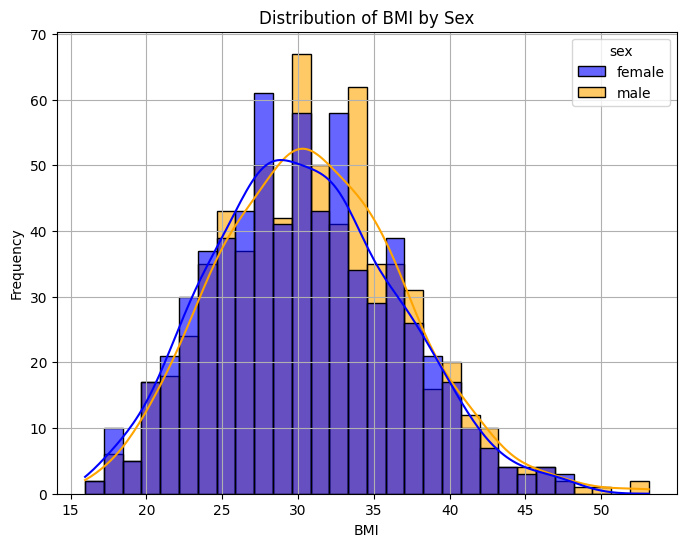

In [ ]:
#Alex Ferrone
# Plot histogram with KDE for BMI, split by sex
plt.figure(figsize=(8, 6))
sns.histplot(df, x='bmi', hue='sex', kde=True, palette=['blue', 'orange'], bins=30, alpha=0.6)

plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Distribution of BMI by Sex')
plt.grid(True)
plt.show()

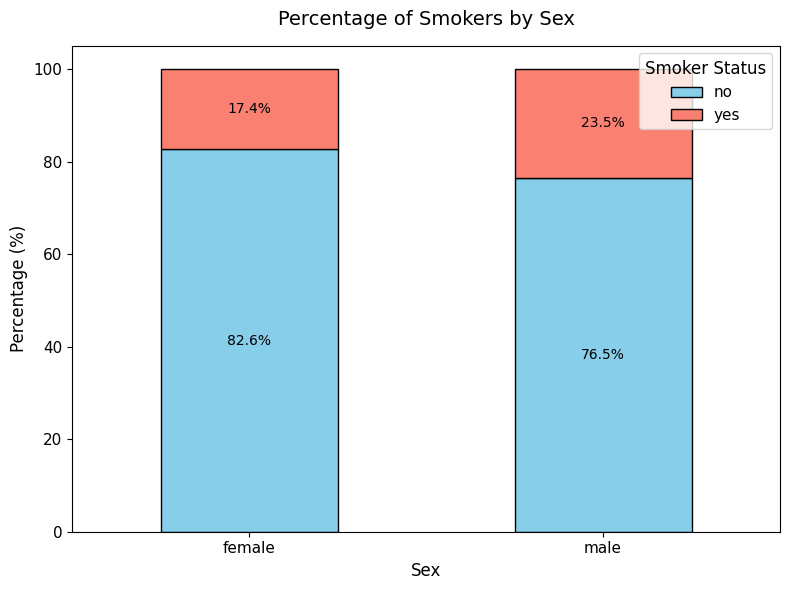

In [ ]:
#Alex Ferrone
# Group data by 'sex' and 'smoker' and calculate percentages
smoker_by_sex = df.groupby(['sex', 'smoker']).size().unstack()

smoker_percentage = (smoker_by_sex.div(smoker_by_sex.sum(axis=1), axis=0)) * 100

ax = smoker_percentage.plot(kind='bar',
                            stacked=True,
                            figsize=(8, 6),
                            color=['skyblue', 'salmon'],
                            edgecolor='black')

plt.title('Percentage of Smokers by Sex', fontsize=14, pad=15)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='Smoker Status', fontsize=11, title_fontsize=12, loc='upper right')

# Add percentage labels to each bar segment
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

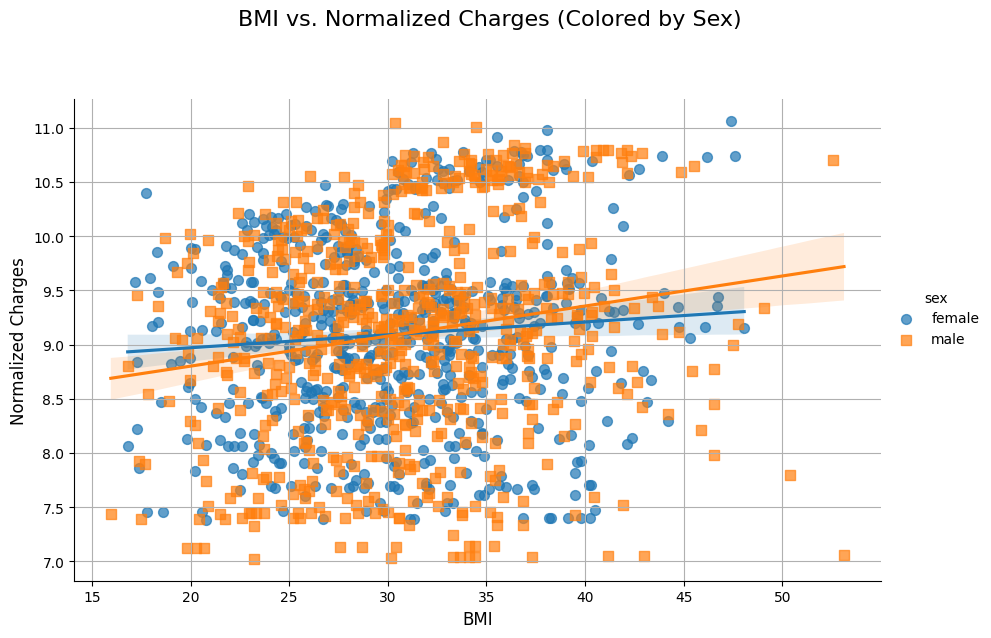

In [ ]:
#Alex Ferrone
g1 = sns.lmplot(
    data=df, x="bmi", y="norm_charges", hue="sex",
    height=6, aspect=1.5, markers=["o", "s"],
    scatter_kws={"alpha": 0.7, "s": 50}
)

g1.set_axis_labels("BMI", "Normalized Charges", fontsize=12)
g1.fig.suptitle("BMI vs. Normalized Charges (Colored by Sex)", y=1.05, fontsize=16)
plt.subplots_adjust(top=0.9)
plt.grid(True)

# Show the plot
plt.show()

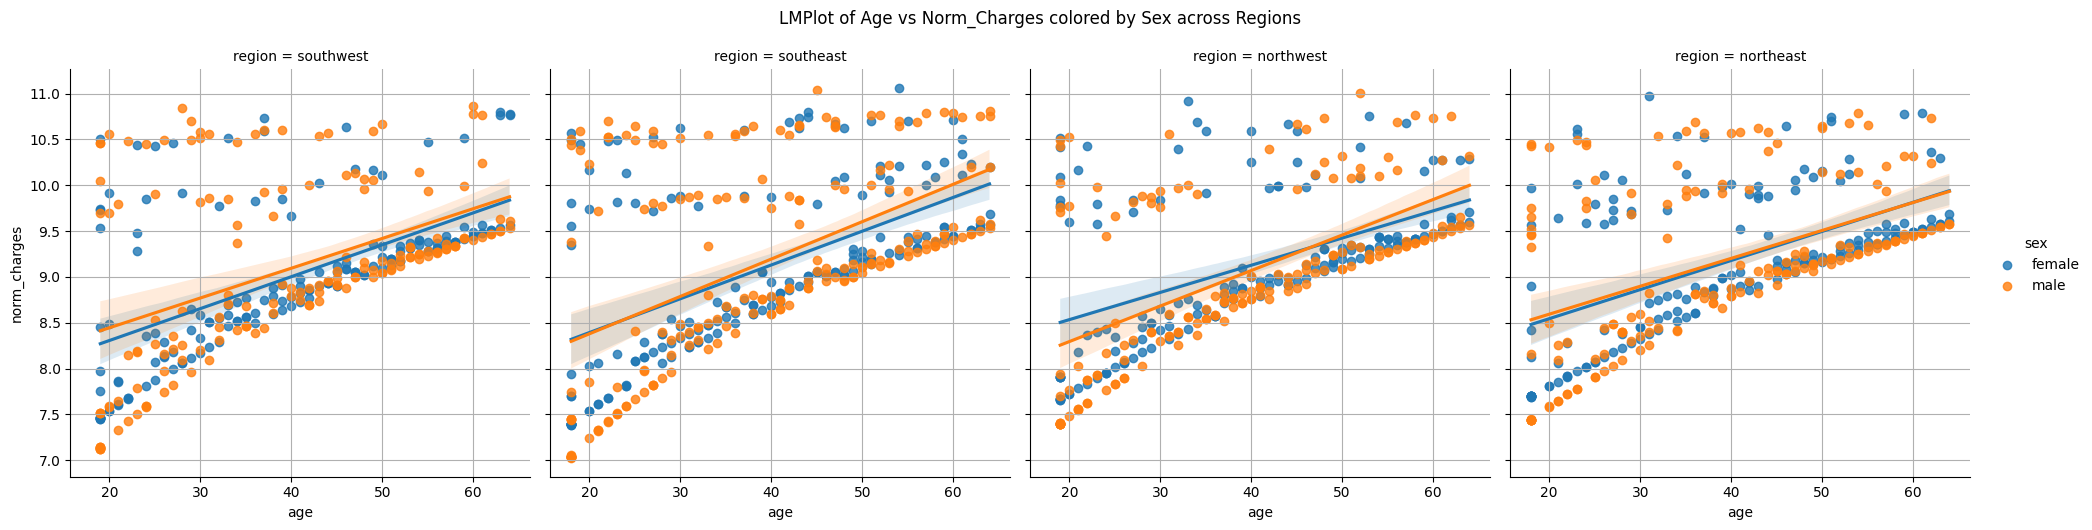

In [ ]:
#Alex Ferrone
#Use the lmplot
g1 = sns.lmplot(data=df, x="age", y="norm_charges", col="region", hue="sex")

for ax in g1.axes.flat:
    ax.grid(True)
# Show the plot
g1.fig.suptitle('LMPlot of Age vs Norm_Charges colored by Sex across Regions', y=1.05)
plt.show()

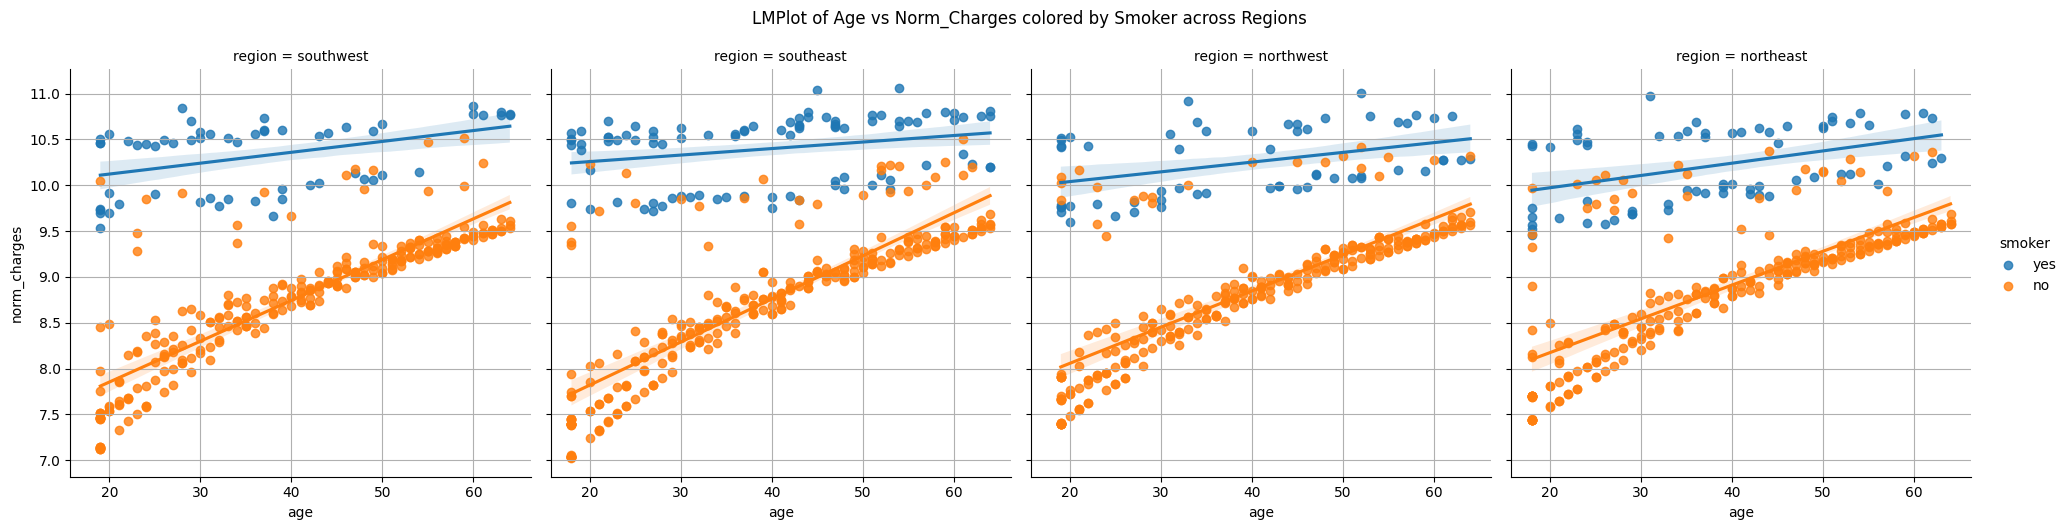

In [ ]:
#Alex Ferrone
#Use the lmplot
g1 = sns.lmplot(data=df, x="age", y="norm_charges", col="region", hue="smoker")

# Show the plot
for ax in g1.axes.flat:
    ax.grid(True)
g1.fig.suptitle('LMPlot of Age vs Norm_Charges colored by Smoker across Regions', y=1.05)
plt.grid(True)
plt.show()

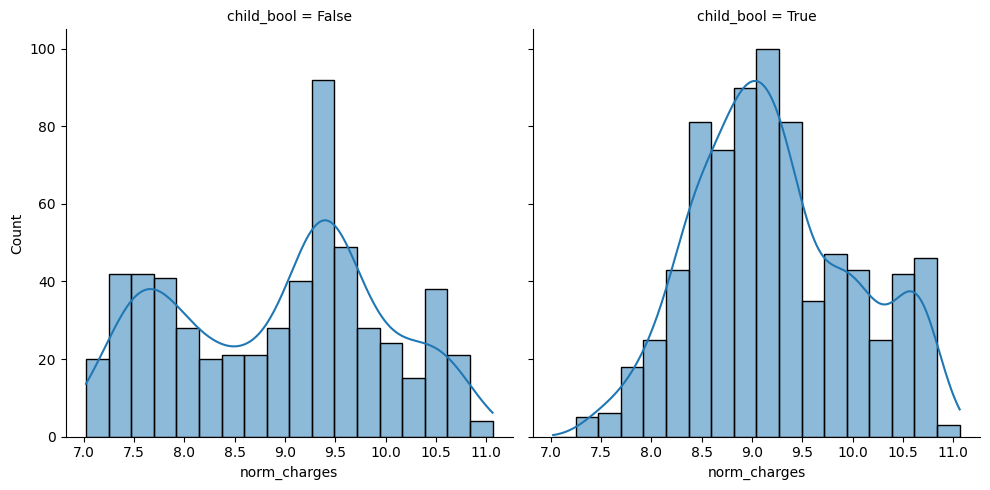

In [ ]:
g4 = sns.displot(data=df, x="norm_charges", col="child_bool", kde=True)

# Show the plot
plt.show()

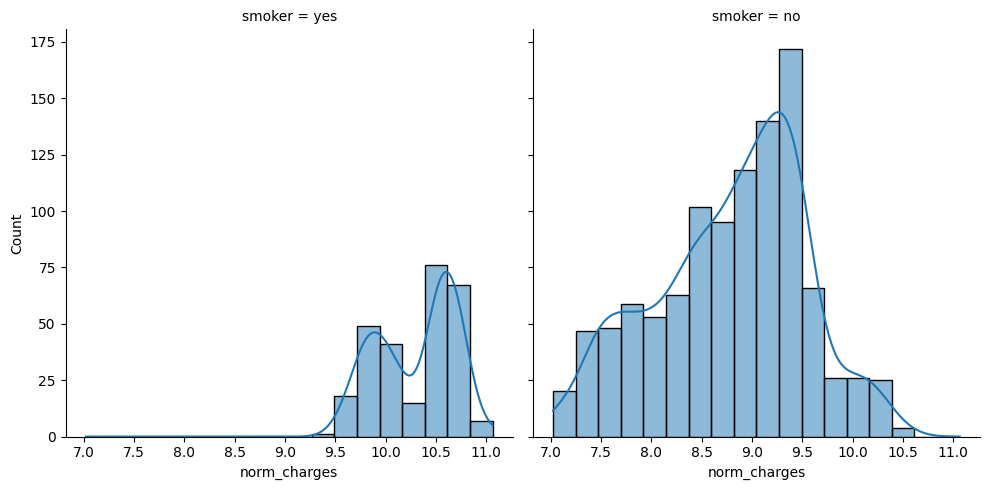

In [ ]:
#Alex Ferrone
#We can also explore their distribution.
g2 = sns.displot(data=df, x="norm_charges", col="smoker", kde=True)

# Show the plot
plt.show()

In [ ]:
#Alex Ferrone
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
dummyColumns = ['child_bool', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']
df[dummyColumns] = df[dummyColumns].astype(int)
df.head()

,age,bmi,children,charges,child_bool,norm_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,9.734176,0,1,0,0,1
1,18,33.770,1,1725.55230,1,7.453302,1,0,0,1,0
2,28,33.000,3,4449.46200,1,8.400538,1,0,0,1,0
3,33,22.705,0,21984.47061,0,9.998092,1,0,1,0,0
4,32,28.880,0,3866.85520,0,8.260197,1,0,1,0,0


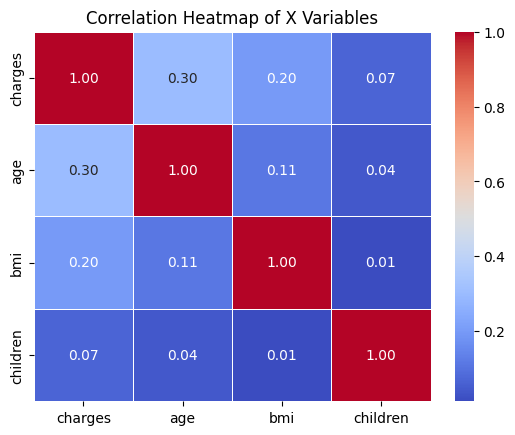

In [ ]:
#Alex Ferrone
corr_df = df[['charges', 'age', 'bmi', 'children']]

corr_matrix = corr_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of X Variables')
plt.show()

In [ ]:
#Alex Ferrone
#X and Y variables
x = df[['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']]

y = df['norm_charges']


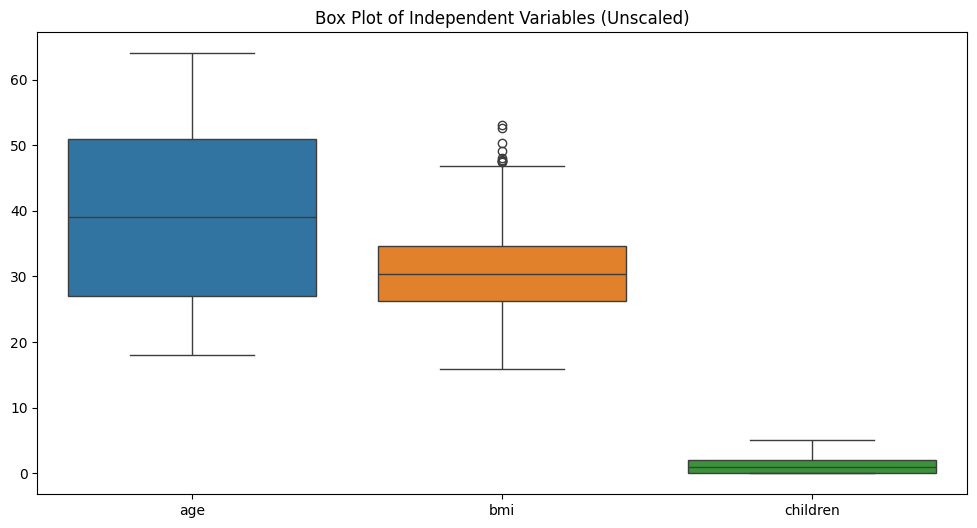

In [ ]:
#Alex Ferrone
continuous_features = ['age', 'bmi', 'children']

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=x[continuous_features])
plt.title('Box Plot of Independent Variables (Unscaled)')
plt.show()

In [ ]:
#Alex Ferrone
#Calculate descriptive statistics
means = x.mean()
std_devs = x.std()
min_vals = x.min()
max_vals = x.max()

print("Means:\n", means)
print("\nStandard Deviations:\n", std_devs)
print("\nMinimum Values:\n", min_vals)
print("\nMaximum Values:\n", max_vals)

#Check normalization conditions
is_standardized = (means.abs() < 1e-6).all() and (std_devs - 1).abs().max() < 1e-6
is_min_max_scaled = ((min_vals >= 0).all() and (max_vals <= 1).all())

print(f"\nAre the features standardized? {is_standardized}")
print(f"Are the features min-max scaled? {is_min_max_scaled}")

Means:
 age                 39.207025
bmi                 30.663397
children             1.094918
sex_male             0.505232
smoker_yes           0.204783
region_northwest     0.242900
region_southeast     0.272048
region_southwest     0.242900
dtype: float64

Standard Deviations:
 age                 14.049960
bmi                  6.098187
children             1.205493
sex_male             0.500160
smoker_yes           0.403694
region_northwest     0.428995
region_southeast     0.445181
region_southwest     0.428995
dtype: float64

Minimum Values:
 age                 18.00
bmi                 15.96
children             0.00
sex_male             0.00
smoker_yes           0.00
region_northwest     0.00
region_southeast     0.00
region_southwest     0.00
dtype: float64

Maximum Values:
 age                 64.00
bmi                 53.13
children             5.00
sex_male             1.00
smoker_yes           1.00
region_northwest     1.00
region_southeast     1.00
region_southwest  

In [ ]:
#Alex Ferrone
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x[['age', 'bmi', 'children']] = scaler.fit_transform(x[['age', 'bmi', 'children']])
print(x[['age', 'bmi', 'children']].describe())

                age           bmi      children
count  1.338000e+03  1.338000e+03  1.338000e+03
mean  -1.805565e-16 -2.124194e-16 -5.576008e-17
std    1.000374e+00  1.000374e+00  1.000374e+00
min   -1.509965e+00 -2.412011e+00 -9.086137e-01
25%   -8.691547e-01 -7.164063e-01 -9.086137e-01
50%   -1.474046e-02 -4.320880e-02 -7.876719e-02
75%    8.396738e-01  6.611572e-01  7.510793e-01
max    1.765289e+00  3.685522e+00  3.240619e+00


<ipython-input-184-6d899e5a4713>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[['age', 'bmi', 'children']] = scaler.fit_transform(x[['age', 'bmi', 'children']])


In [ ]:
#Alex Ferrone
x = sm.add_constant(x)

X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.2,
                                                    random_state = 1502)
X_train.head(2)

,const,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
1314,1.0,-0.655551,-1.149689,1.580926,0,1,1,0,0
283,1.0,1.124479,0.284060,-0.078767,0,0,0,0,0


In [ ]:
#Alex Ferrone
#Get the linear regression
model = sm.OLS(y_train, X_train).fit()
print(model.summary())
predictions = model.predict(X_test)
predictions[:4]
#Accuracy assessment
print("MAE:", round(mean_absolute_error(y_test, predictions),4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, predictions)), 4))

                            OLS Regression Results                            
Dep. Variable:           norm_charges   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     468.2
Date:                Wed, 23 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:18:54   Log-Likelihood:                -615.21
No. Observations:                1070   AIC:                             1248.
Df Residuals:                    1061   BIC:                             1293.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.9131      0.031  

In [ ]:
#Alex Ferrone

# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_train)

poly_model = sm.OLS(y_train, X_poly).fit()

print(poly_model.summary())

# Transform X_test using the same PolynomialFeatures instance
X_poly_test = poly.transform(X_test)

# Predict using the trained OLS model
poly_predictions = poly_model.predict(X_poly_test)

# Display the first 4 predictions
print(poly_predictions[:4])

# Calculate and print MAE and RMSE
print("MAE:", round(mean_absolute_error(y_test, poly_predictions), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, poly_predictions)), 4))

                            OLS Regression Results                            
Dep. Variable:           norm_charges   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     164.5
Date:                Wed, 23 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:18:54   Log-Likelihood:                -403.33
No. Observations:                1070   AIC:                             880.7
Df Residuals:                    1033   BIC:                             1065.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5222      0.019    232.849      0.0

In [ ]:
#Akanksha Rai
#Get VIF and Durbin-Watson Statistic
#for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

# Display VIF results
print(vif_data)
#Durbin-Watson Statistic
x = sm.add_constant(x)

# Fit the regression model
model = sm.OLS(y, x).fit()

# Calculate the Durbin-Watson statistic
dw_statistic = sm.stats.durbin_watson(model.resid)
print(f'Durbin-Watson Statistic: {dw_statistic}')

            feature       VIF
0             const  5.428992
1               age  1.016822
2               bmi  1.106630
3          children  1.004011
4          sex_male  1.008900
5        smoker_yes  1.012074
6  region_northwest  1.518823
7  region_southeast  1.652230
8  region_southwest  1.529411
Durbin-Watson Statistic: 2.046442878102474


Accuracy: 0.91
Precision: 0.89
Recall: 0.93
F1 Score: 0.91


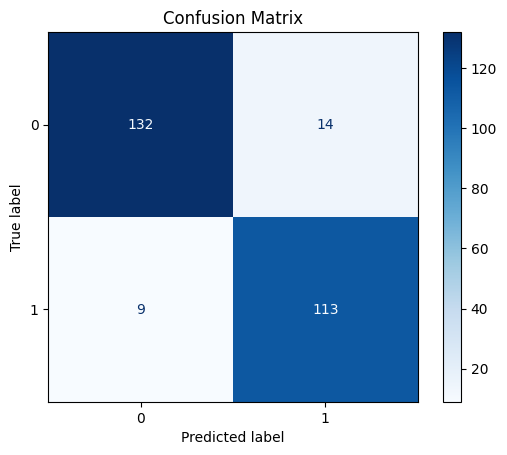

In [ ]:
#Akanksha Rai
#Create a confusion matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

median_charges = df['norm_charges'].median()
df['high_charge'] = np.where(df['norm_charges'] > median_charges, 1, 0)
y = df['high_charge']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit a logistic regression model with increased iterations
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

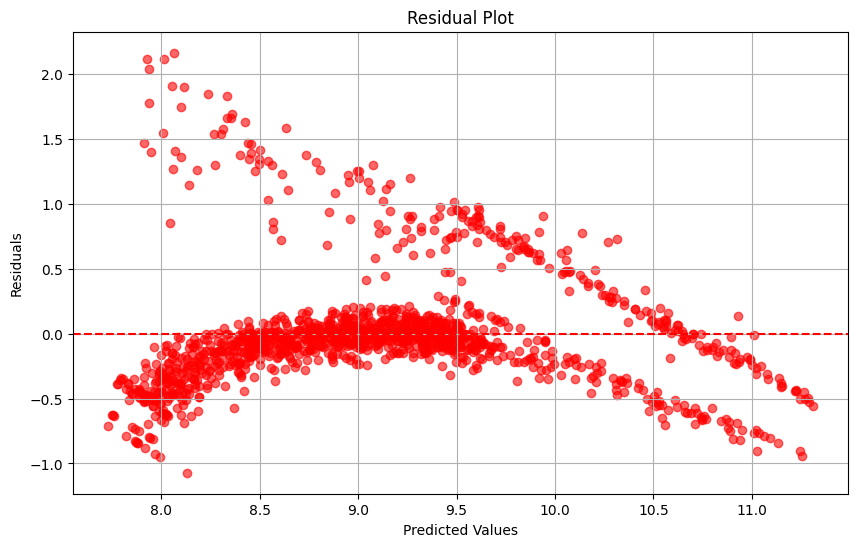

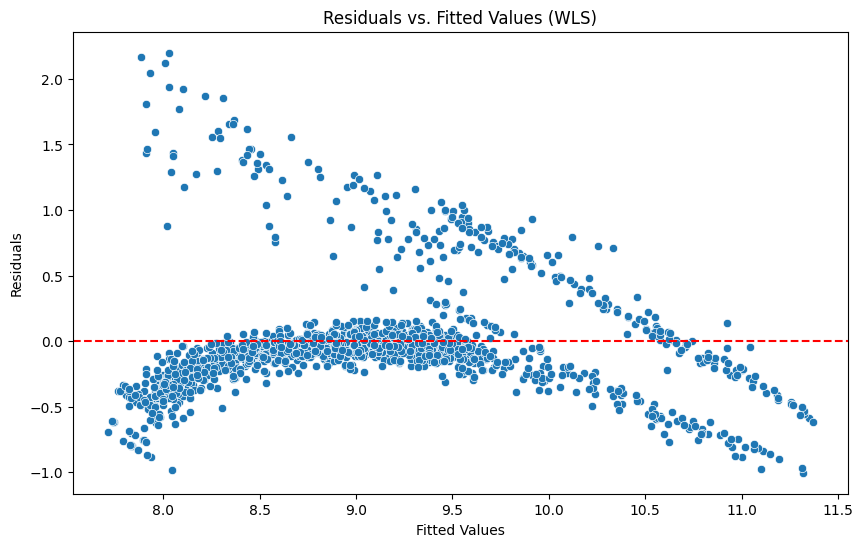

In [ ]:
#Akanksha Rai
#Make a residual plot
y = df['norm_charges']
x = sm.add_constant(x)
# Fit the regression model
model = sm.OLS(y, x).fit()

# Calculate residuals
residuals = model.resid
predicted = model.predict(x)
weights = 1 / model.get_prediction().se_mean**2

# Fit the WLS model
wls_model = sm.WLS(y, x, weights=weights).fit()
# Create the residual plot
plt.figure(figsize=(10, 6))
plt.scatter(predicted, residuals, color='red', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')  # Line at y=0
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Residuals vs. Fitted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=wls_model.fittedvalues, y=wls_model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values (WLS)')
plt.show()

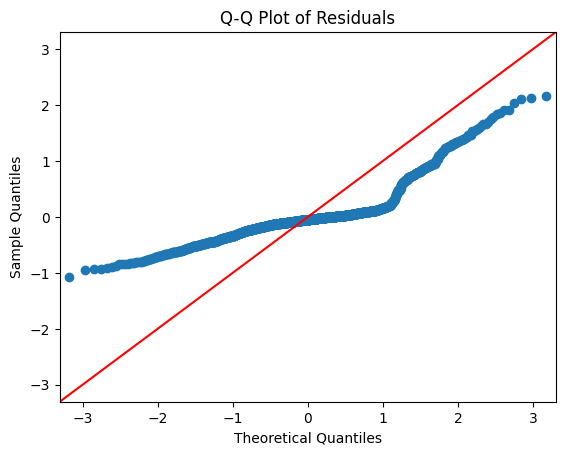

In [ ]:
#Make a Q-Q plot
#Akanksha Rai
x = sm.add_constant(x)
# Fit the regression model
model = sm.OLS(y, x).fit()
# Calculate residuals
residuals = model.resid
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

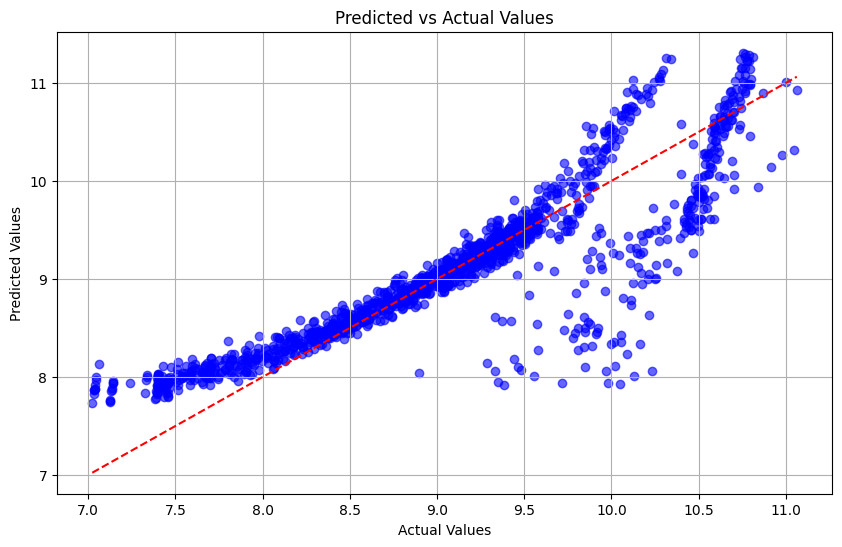

In [ ]:
#Plot predicted vs actual values
#Akanksha Rai
# Calculate residuals
# Fit the regression model
model = sm.OLS(y, x).fit()
residuals = model.resid
predicted = model.predict(x)
plt.figure(figsize=(10, 6))
plt.scatter(y, predicted, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # Line of perfect prediction
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [ ]:
"""Code contribution was 50/50.
Alex Ferrone: Worked on data cleaning/prep creation of plots and regressions.
Akanksha Rai: Worked on creating validation testing plots and statistics and improved plot readibility.
"""

'Code contribution was 50/50.\nAlex Ferrone: Worked on data cleaning/prep creation of plots and regressions.\nAkanksha Rai: Worked on creating validation testing plots and statistics and improved plot readibility.\n'